# GoodReads Exploratory Data Analysis

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
colors = sns.color_palette('muted')

In [2]:
def load_data(filename, directory="data/raw"):
    """Load data from a CSV file."""
    if os.path.basename(os.getcwd()) == "notebooks":
        file_path = Path("..") / directory / filename
    else:
        file_path = Path(directory) / filename
    
    # load the data
    df = pd.read_csv(file_path)
    print(f"Loaded {filename}: {len(df)} rows")
    return df

In [3]:
print("Loading datasets...\n")

# create a dictionary to hold our dataframes
data = {
    "ratings": load_data("ratings.csv"),
    "books": load_data("books.csv"),
    "to_read": load_data("to_read.csv"),
    "book_tags": load_data("book_tags.csv"),
    "tags": load_data("tags.csv")
}

print("\nAll datasets loaded successfully!")

Loading datasets...

Loaded ratings.csv: 5976479 rows
Loaded books.csv: 10000 rows
Loaded to_read.csv: 912705 rows
Loaded book_tags.csv: 999912 rows
Loaded tags.csv: 34252 rows

All datasets loaded successfully!


## Rating Distribution and User Behavior Analysis

In [4]:
# extract dataframes for easier reference
ratings_df = data['ratings']
books_df = data['books']
to_read_df = data['to_read']
book_tags_df = data['book_tags']
tags_df = data['tags']

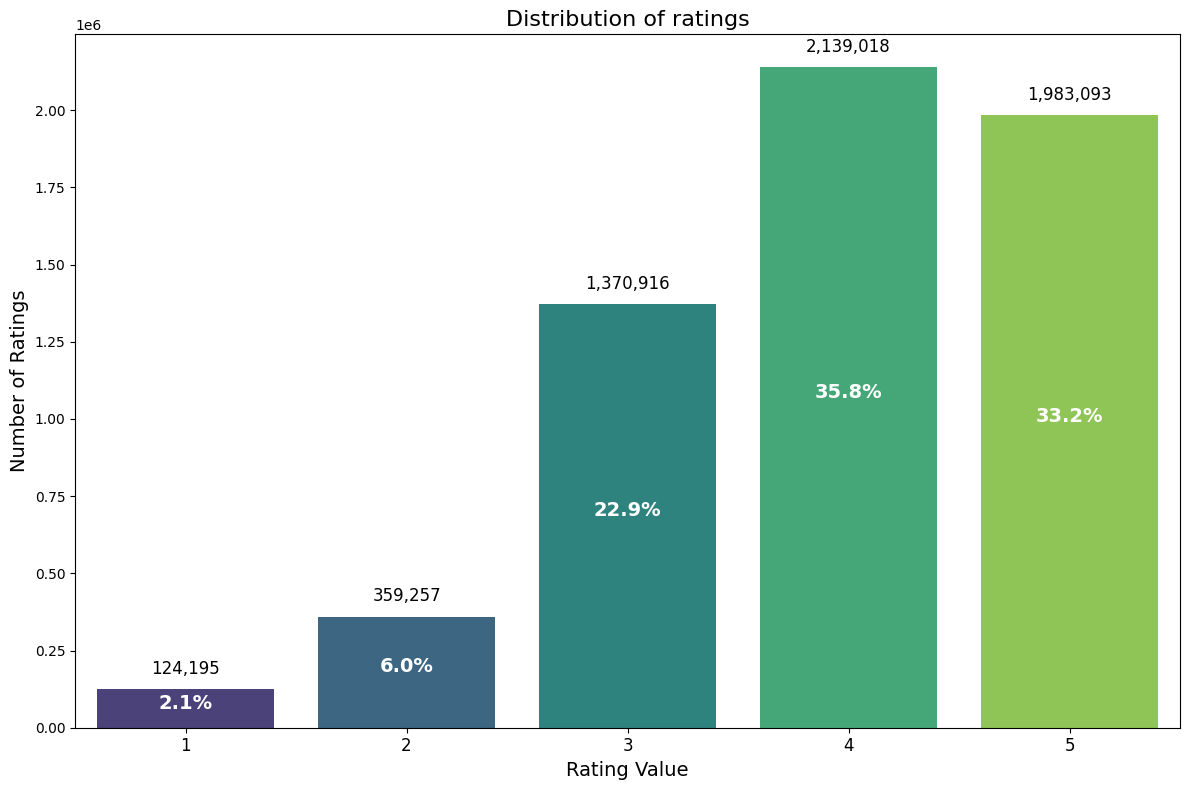

In [5]:
# plot rating distribution with percentages
plt.figure(figsize=(12, 8))
rating_counts = ratings_df['rating'].value_counts().sort_index()
total_ratings = len(ratings_df)

ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# add count and percentage labels
for i, (rating, count) in enumerate(rating_counts.items()):
    percentage = count / total_ratings * 100
    ax.text(i, count + 50000, f'{count:,}', ha='center', fontsize=12)
    ax.text(i, count/2, f'{percentage:.1f}%', ha='center', color='white', fontsize=14, fontweight='bold')

plt.title('Distribution of ratings', fontsize=16)
plt.xlabel('Rating Value', fontsize=14)
plt.ylabel('Number of Ratings', fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
# calculate rating statistics
print("\nRating Statistics:")
print(f"Mean rating: {ratings_df['rating'].mean():.2f}")
print(f"Median rating: {ratings_df['rating'].median()}")
print(f"Mode rating: {ratings_df['rating'].mode()[0]}")
print(f"Rating positivity ratio (4-5 vs 1-2): {len(ratings_df[ratings_df['rating'] >= 4]) / len(ratings_df[ratings_df['rating'] <= 2]):.2f}")


Rating Statistics:
Mean rating: 3.92
Median rating: 4.0
Mode rating: 4
Rating positivity ratio (4-5 vs 1-2): 8.53


In [7]:
# number of ratings per user
user_rating_counts = ratings_df['user_id'].value_counts()

In [8]:
# calculate rating statistics per user
print("\nUser Rating Behavior:")
print(f"Minimum ratings per user: {user_rating_counts.min()}")
print(f"Maximum ratings per user: {user_rating_counts.max()}")
print(f"Mean ratings per user: {user_rating_counts.mean():.2f}")
print(f"Median ratings per user: {user_rating_counts.median()}")


User Rating Behavior:
Minimum ratings per user: 19
Maximum ratings per user: 200
Mean ratings per user: 111.87
Median ratings per user: 111.0


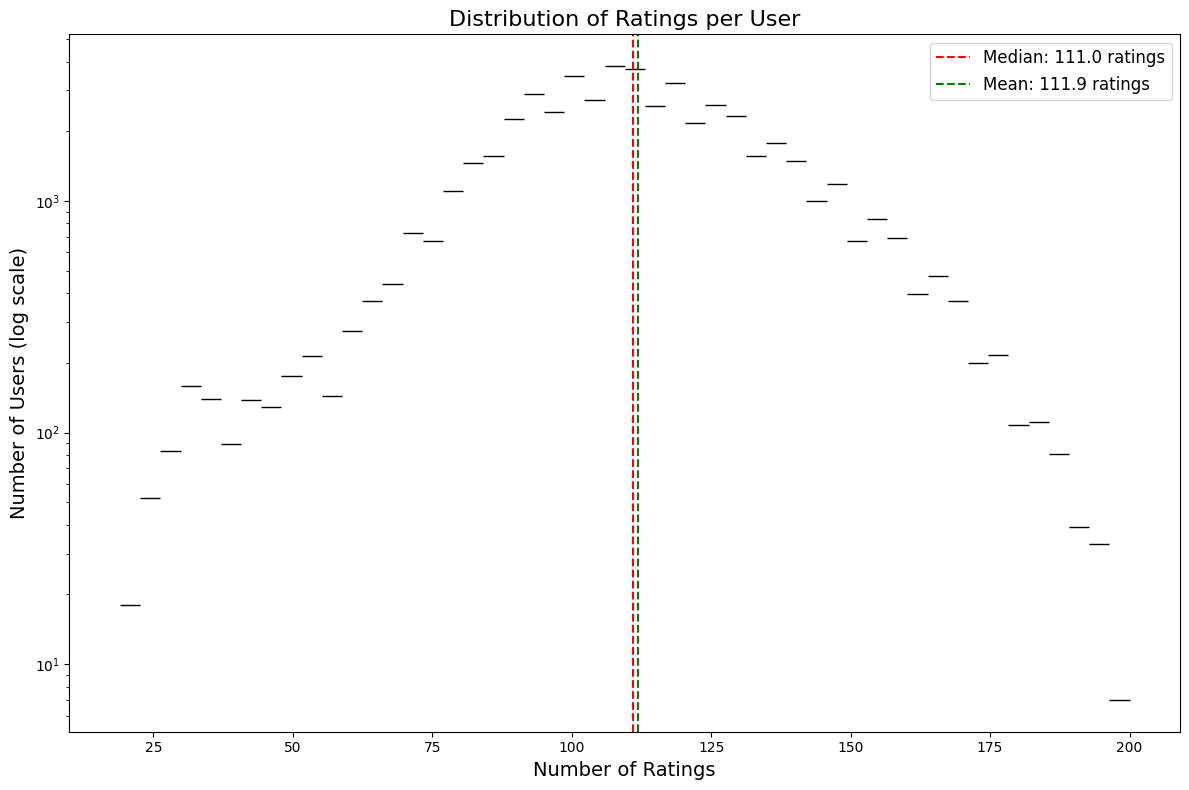

In [9]:
# plot distribution of ratings per user
plt.figure(figsize=(12, 8))
sns.histplot(user_rating_counts, bins=50, log_scale=(False, True), color=colors[0])
plt.axvline(x=user_rating_counts.median(), color='red', linestyle='--',
            label=f'Median: {user_rating_counts.median()} ratings')
plt.axvline(x=user_rating_counts.mean(), color='green', linestyle='--',
            label=f'Mean: {user_rating_counts.mean():.1f} ratings')
plt.title('Distribution of Ratings per User', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=14)
plt.ylabel('Number of Users (log scale)', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

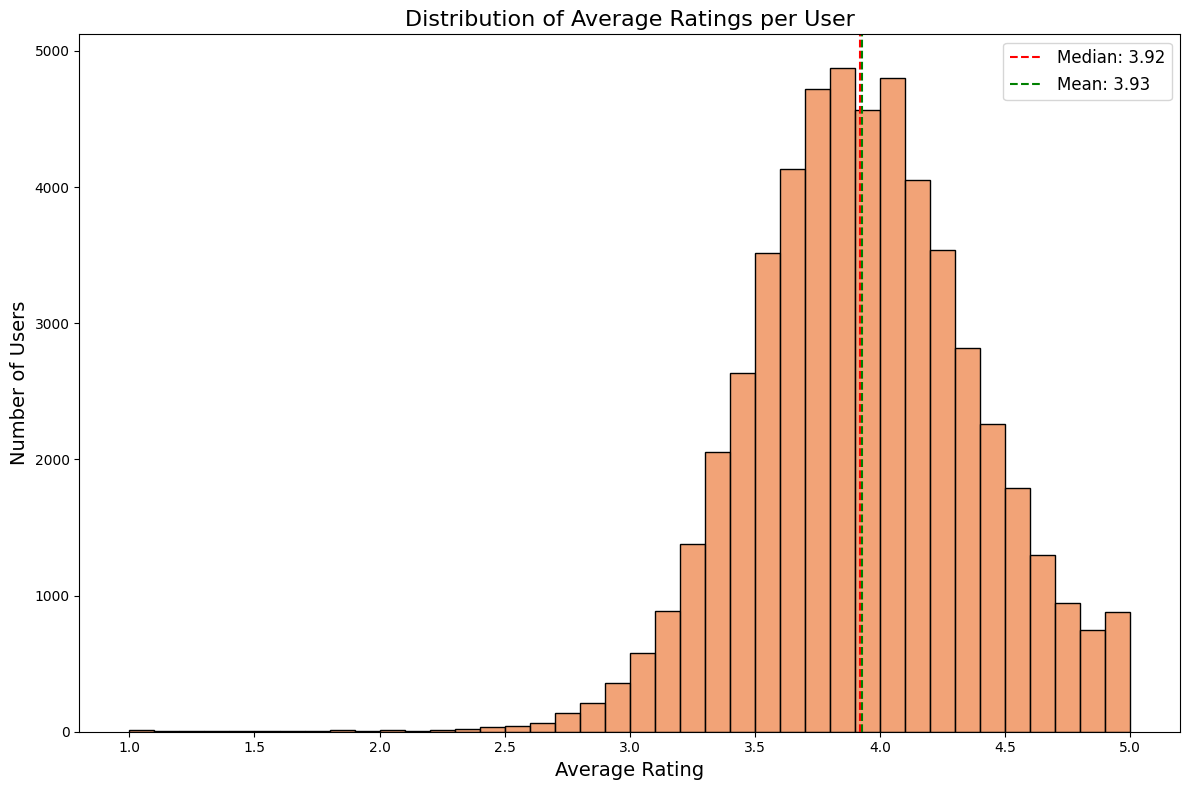

In [10]:
# plot average ratings per user
avg_ratings_per_user = ratings_df.groupby('user_id')['rating'].mean()

plt.figure(figsize=(12, 8))
sns.histplot(avg_ratings_per_user, bins=40, color=colors[1])
plt.axvline(x=avg_ratings_per_user.median(), color='red', linestyle='--',
            label=f'Median: {avg_ratings_per_user.median():.2f}')
plt.axvline(x=avg_ratings_per_user.mean(), color='green', linestyle='--',
            label=f'Mean: {avg_ratings_per_user.mean():.2f}')
plt.title('Distribution of Average Ratings per User', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
# identify users with extreme rating behavior
print("\nUsers with Extreme Rating Patterns:")

# users who rate everything highly (average rating > 4.5 with at least 50 ratings)
high_raters = avg_ratings_per_user[(avg_ratings_per_user > 4.5) & (user_rating_counts >= 50)]
print(f"Users who give mostly 5-star ratings (avg > 4.5, min 50 ratings): {len(high_raters)}")

# users who rate everything poorly (average rating < 2.5 with at least 50 ratings)
low_raters = avg_ratings_per_user[(avg_ratings_per_user < 2.5) & (user_rating_counts >= 50)]
print(f"Users who give mostly low ratings (avg < 2.5, min 50 ratings): {len(low_raters)}")

# users with high variance in ratings (might be more discriminating)
rating_std_per_user = ratings_df.groupby('user_id')['rating'].std()
high_var_raters = rating_std_per_user[(rating_std_per_user > 1.5) & (user_rating_counts >= 50)]
print(f"Users with high rating variance (std > 1.5, min 50 ratings): {len(high_var_raters)}")


Users with Extreme Rating Patterns:
Users who give mostly 5-star ratings (avg > 4.5, min 50 ratings): 5489
Users who give mostly low ratings (avg < 2.5, min 50 ratings): 149
Users with high rating variance (std > 1.5, min 50 ratings): 157
Users with high rating variance (std > 1.5, min 50 ratings): 157


## Book Popularity and Rating Analysis

In [12]:
# number of ratings per book
book_rating_counts = ratings_df['book_id'].value_counts()

# calculate book popularity statistics
print("\nBook Popularity Statistics:")
print(f"Minimum ratings per book: {book_rating_counts.min()}")
print(f"Maximum ratings per book: {book_rating_counts.max()}")
print(f"Mean ratings per book: {book_rating_counts.mean():.2f}")
print(f"Median ratings per book: {book_rating_counts.median()}")


Book Popularity Statistics:
Minimum ratings per book: 8
Maximum ratings per book: 22806
Mean ratings per book: 597.65
Median ratings per book: 248.0


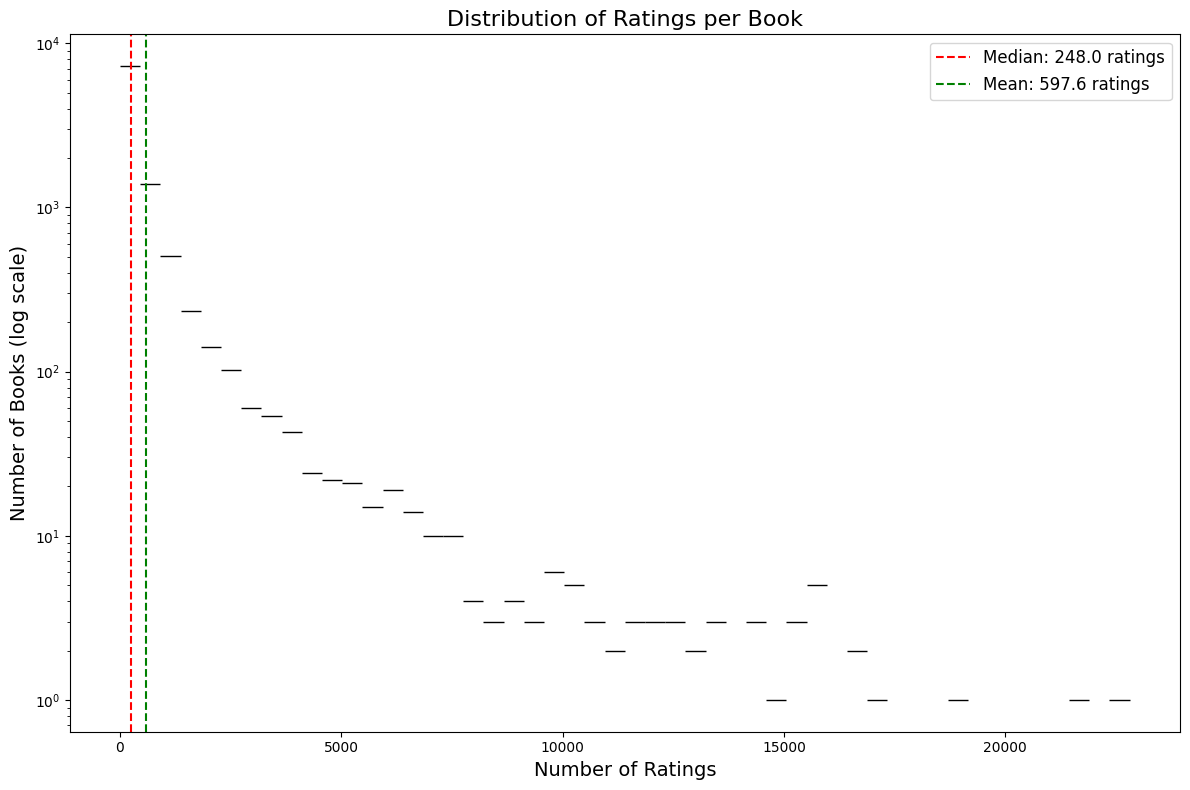

In [13]:
# plot distribution of ratings per book
plt.figure(figsize=(12, 8))
sns.histplot(book_rating_counts, bins=50, log_scale=(False, True), color=colors[2])
plt.axvline(x=book_rating_counts.median(), color='red', linestyle='--', 
            label=f'Median: {book_rating_counts.median()} ratings')
plt.axvline(x=book_rating_counts.mean(), color='green', linestyle='--', 
            label=f'Mean: {book_rating_counts.mean():.1f} ratings')
plt.title('Distribution of Ratings per Book', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=14)
plt.ylabel('Number of Books (log scale)', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

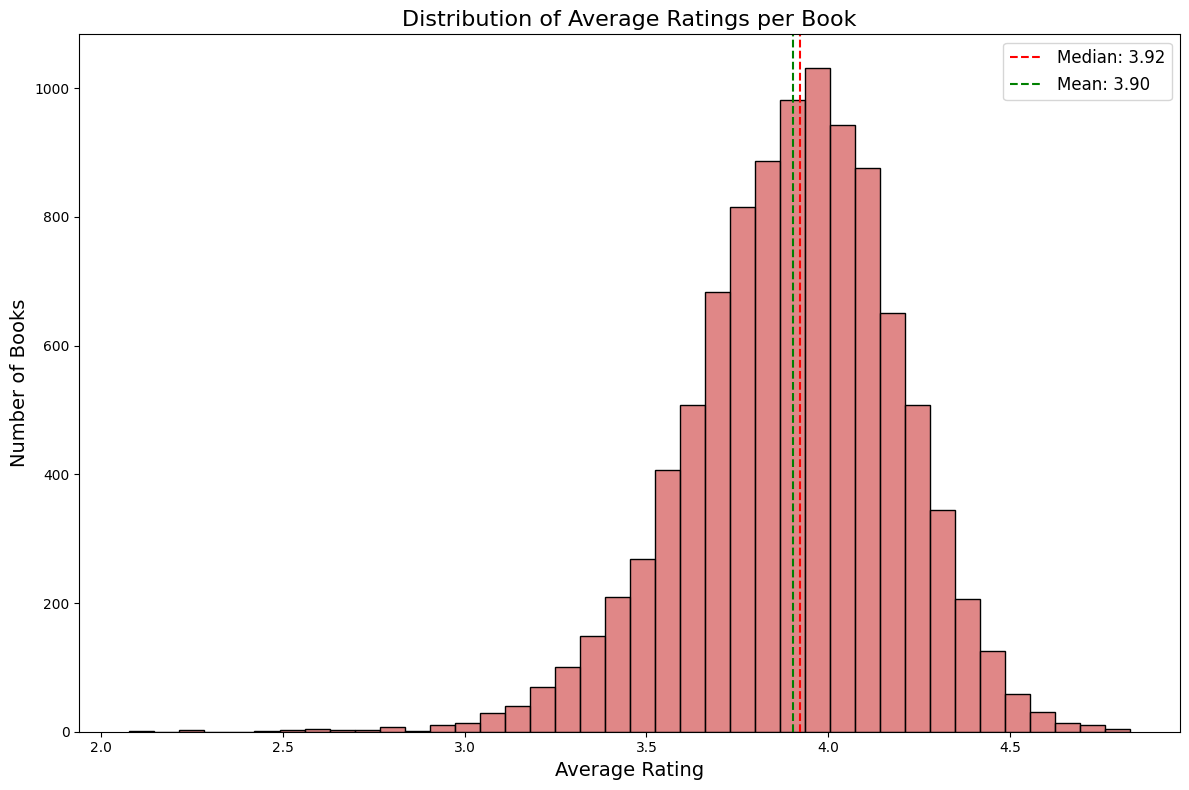

In [14]:
# average rating per book
avg_rating_per_book = ratings_df.groupby('book_id')['rating'].mean()

plt.figure(figsize=(12, 8))
sns.histplot(avg_rating_per_book, bins=40, color=colors[3])
plt.axvline(x=avg_rating_per_book.median(), color='red', linestyle='--', 
            label=f'Median: {avg_rating_per_book.median():.2f}')
plt.axvline(x=avg_rating_per_book.mean(), color='green', linestyle='--', 
            label=f'Mean: {avg_rating_per_book.mean():.2f}')
plt.title('Distribution of Average Ratings per Book', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Number of Books', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [15]:
# top 20 most popular books
top_books = book_rating_counts.sort_values(ascending=False).head(20)
top_books_df = pd.DataFrame({
    'book_id': top_books.index,
    'count': top_books.values
})

# merge with book info
top_books_df = top_books_df.merge(books_df[['book_id', 'title', 'authors', 'average_rating']], on='book_id')
top_books_df['avg_rating_goodreads'] = top_books_df['average_rating']
top_books_df['avg_rating_dataset'] = [avg_rating_per_book[book_id] for book_id in top_books_df['book_id']]

In [16]:
print("\nTop 20 Most Popular Books:")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 40)
print(top_books_df[['title', 'authors', 'count', 'avg_rating_dataset', 'avg_rating_goodreads']].to_string(index=False))


Top 20 Most Popular Books:
                                                       title                                 authors  count  avg_rating_dataset  avg_rating_goodreads
                     The Hunger Games (The Hunger Games, #1)                         Suzanne Collins  22806            4.279707                  4.34
    Harry Potter and the Sorcerer's Stone (Harry Potter, #1)             J.K. Rowling, Mary GrandPré  21850            4.351350                  4.44
                                       To Kill a Mockingbird                              Harper Lee  19088            4.329369                  4.25
                                     Twilight (Twilight, #1)                         Stephenie Meyer  16931            3.214341                  3.57
                                            The Great Gatsby                     F. Scott Fitzgerald  16604            3.772224                  3.89
                        Catching Fire (The Hunger Games, #2)            

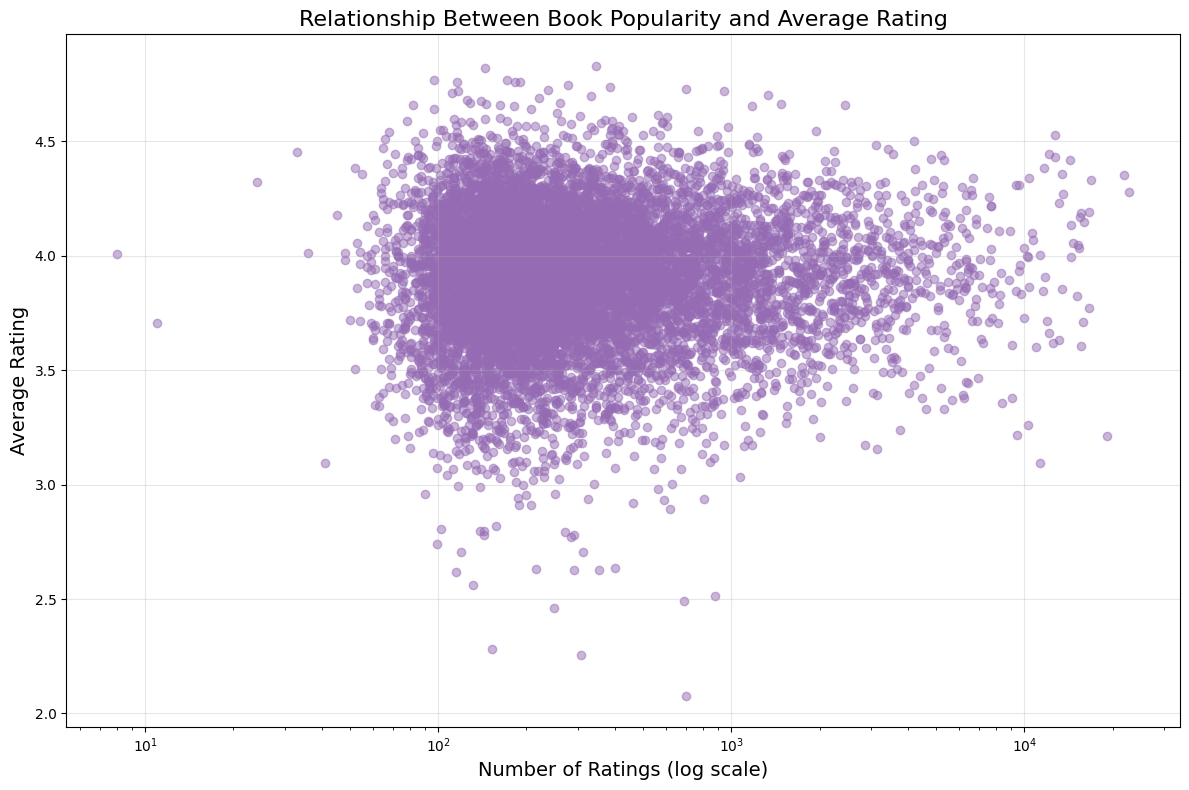

In [17]:
# relationship between popularity and rating
plt.figure(figsize=(12, 8))
plt.scatter(book_rating_counts, avg_rating_per_book, alpha=0.5, color=colors[4])
plt.xscale('log')
plt.title('Relationship Between Book Popularity and Average Rating', fontsize=16)
plt.xlabel('Number of Ratings (log scale)', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# calculate correlation 
correlation = np.corrcoef(book_rating_counts, avg_rating_per_book)[0, 1]
print(f"\nCorrelation between number of ratings and average rating: {correlation:.3f}")


Correlation between number of ratings and average rating: 0.024


In [19]:
# are there any highly rated but unpopular books?
hidden_gems = avg_rating_per_book[(avg_rating_per_book > 4.5) & (book_rating_counts < 100)]
print(f"\nNumber of 'hidden gems' (avg rating > 4.5, < 100 ratings): {len(hidden_gems)}")


Number of 'hidden gems' (avg rating > 4.5, < 100 ratings): 9


In [20]:
# get details of some hidden gems
if len(hidden_gems) > 0:
    hidden_gems_df = pd.DataFrame({
        'book_id': hidden_gems.index,
        'avg_rating': hidden_gems.values,
        'num_ratings': [book_rating_counts[book_id] for book_id in hidden_gems.index]
    })
    hidden_gems_df = hidden_gems_df.merge(books_df[['book_id', 'title', 'authors']], on='book_id')
    print("\nSample of Hidden Gems:")
    print(hidden_gems_df.sort_values('avg_rating', ascending=False).head(10)[['title', 'authors', 'avg_rating', 'num_ratings']].to_string(index=False))


Sample of Hidden Gems:
                                                       title                                    authors  avg_rating  num_ratings
                                             ESV Study Bible Anonymous, Lane T. Dennis, Wayne A. Grudem    4.818182           88
                                                   The Divan                                      Hafez    4.720000           75
                    The Holy Bible: English Standard Version                                  Anonymous    4.666667           99
          One Piece, Volume 38: Rocketman!! (One Piece, #38)                               Eiichirō Oda    4.657534           73
                                    Mark of the Lion Trilogy                            Francine Rivers    4.585106           94
                                          This is Not My Hat                                Jon Klassen    4.584416           77
Praying God's Word: Breaking Free From Spiritual Strongholds             

## Book Metadata Analysis

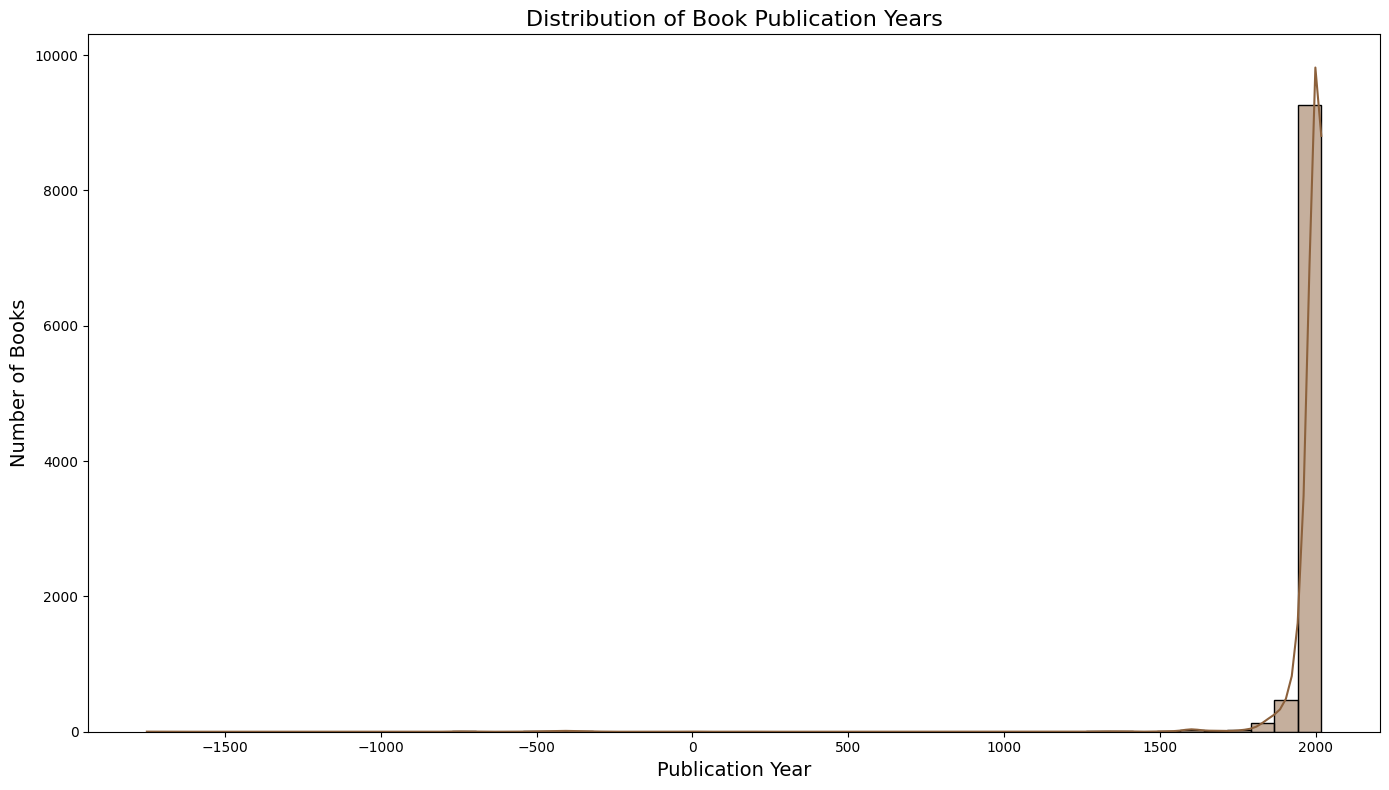


Publication Year Statistics:
Earliest publication year: -1750
Latest publication year: 2017
Median publication year: 2004


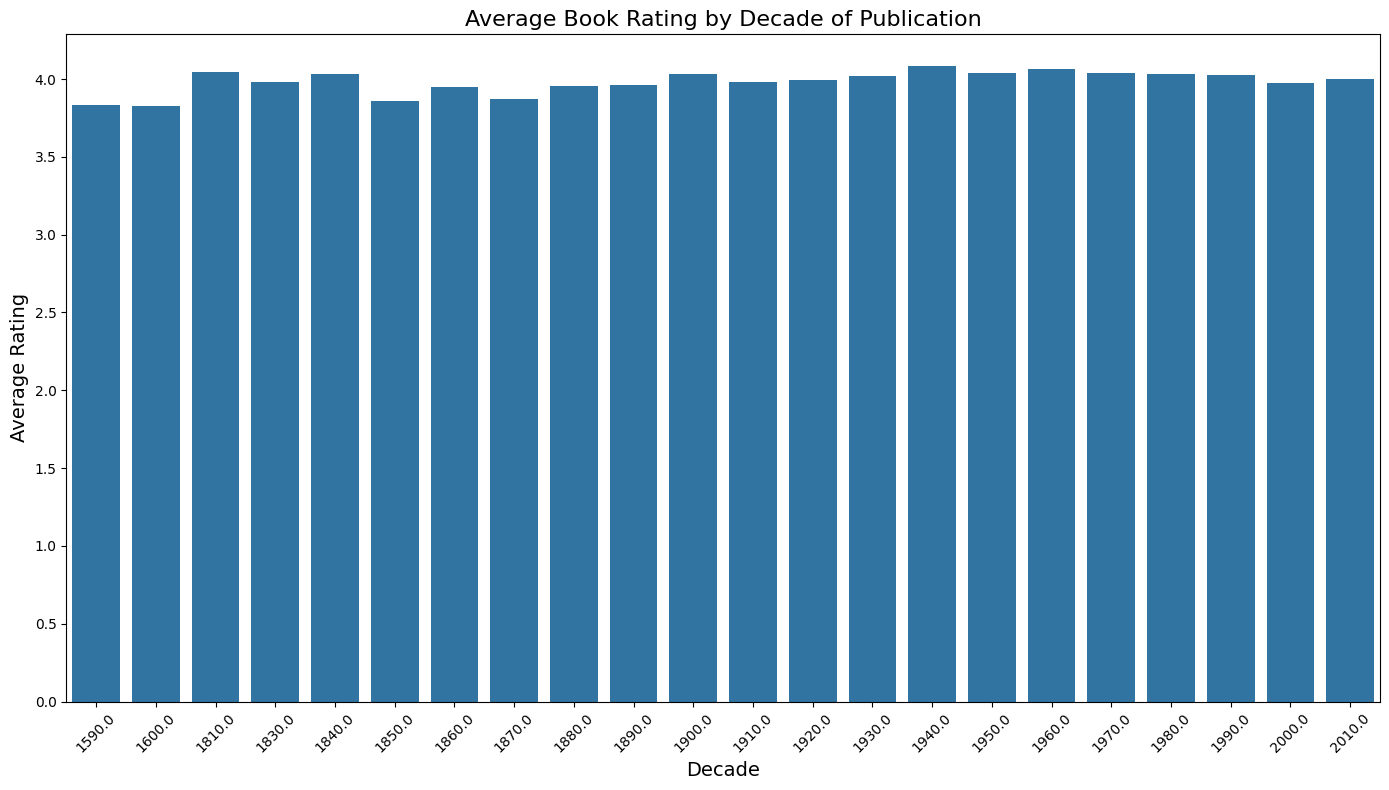

In [21]:
# year of publication analysis
if 'original_publication_year' in books_df.columns:
    # remove missing values
    pub_years = books_df['original_publication_year'].dropna()

    plt.figure(figsize=(14, 8))
    sns.histplot(pub_years, bins=50, kde=True, color=colors[5])
    plt.title('Distribution of Book Publication Years', fontsize=16)
    plt.xlabel('Publication Year', fontsize=14)
    plt.ylabel('Number of Books', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nPublication Year Statistics:")
    print(f"Earliest publication year: {pub_years.min():.0f}")
    print(f"Latest publication year: {pub_years.max():.0f}")
    print(f"Median publication year: {pub_years.median():.0f}")
    
    # relationship between publication year and rating
    book_year_rating = books_df[['book_id', 'original_publication_year', 'average_rating']].dropna()
    
    # group by decade and calculate average rating
    book_year_rating['decade'] = (book_year_rating['original_publication_year'] // 10) * 10
    decade_ratings = book_year_rating.groupby('decade')['average_rating'].mean()
    decade_counts = book_year_rating.groupby('decade').size()
    
    # only include decades with at least 10 books
    valid_decades = decade_counts[decade_counts >= 10].index
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x=decade_ratings[valid_decades].index, y=decade_ratings[valid_decades].values)
    plt.title('Average Book Rating by Decade of Publication', fontsize=16)
    plt.xlabel('Decade', fontsize=14)
    plt.ylabel('Average Rating', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

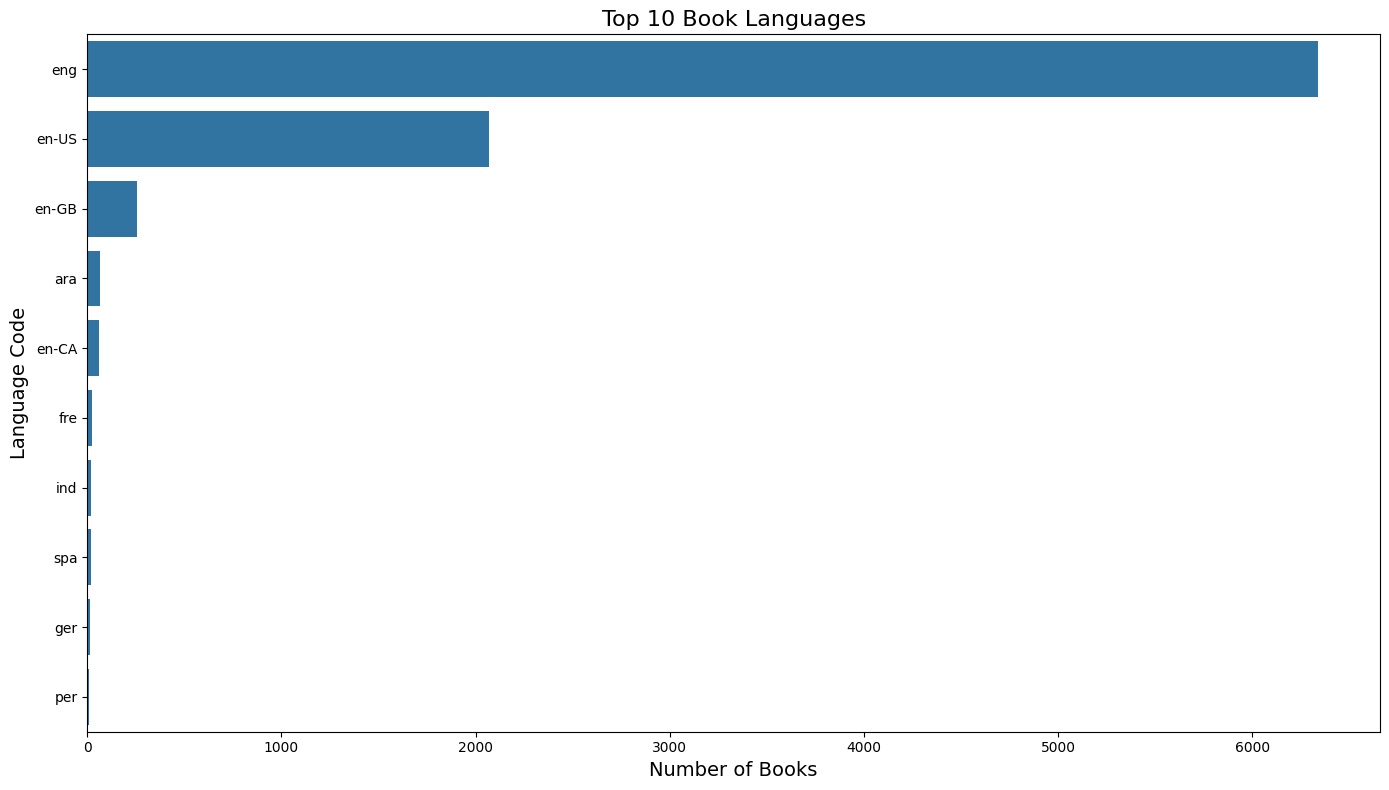


Language Distribution:
eng: 6341 books (71.1%)
en-US: 2070 books (23.2%)
en-GB: 257 books (2.9%)
ara: 64 books (0.7%)
en-CA: 58 books (0.7%)
fre: 25 books (0.3%)
ind: 21 books (0.2%)
spa: 20 books (0.2%)
ger: 13 books (0.1%)
per: 7 books (0.1%)


In [22]:
# language analysis
if 'language_code' in books_df.columns:
    # remove missing values
    languages = books_df['language_code'].dropna()
    
    # top 10 languages
    top_languages = languages.value_counts().head(10)
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x=top_languages.values, y=top_languages.index)
    plt.title('Top 10 Book Languages', fontsize=16)
    plt.xlabel('Number of Books', fontsize=14)
    plt.ylabel('Language Code', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nLanguage Distribution:")
    for lang, count in top_languages.items():
        percentage = count / len(languages) * 100
        print(f"{lang}: {count} books ({percentage:.1f}%)")

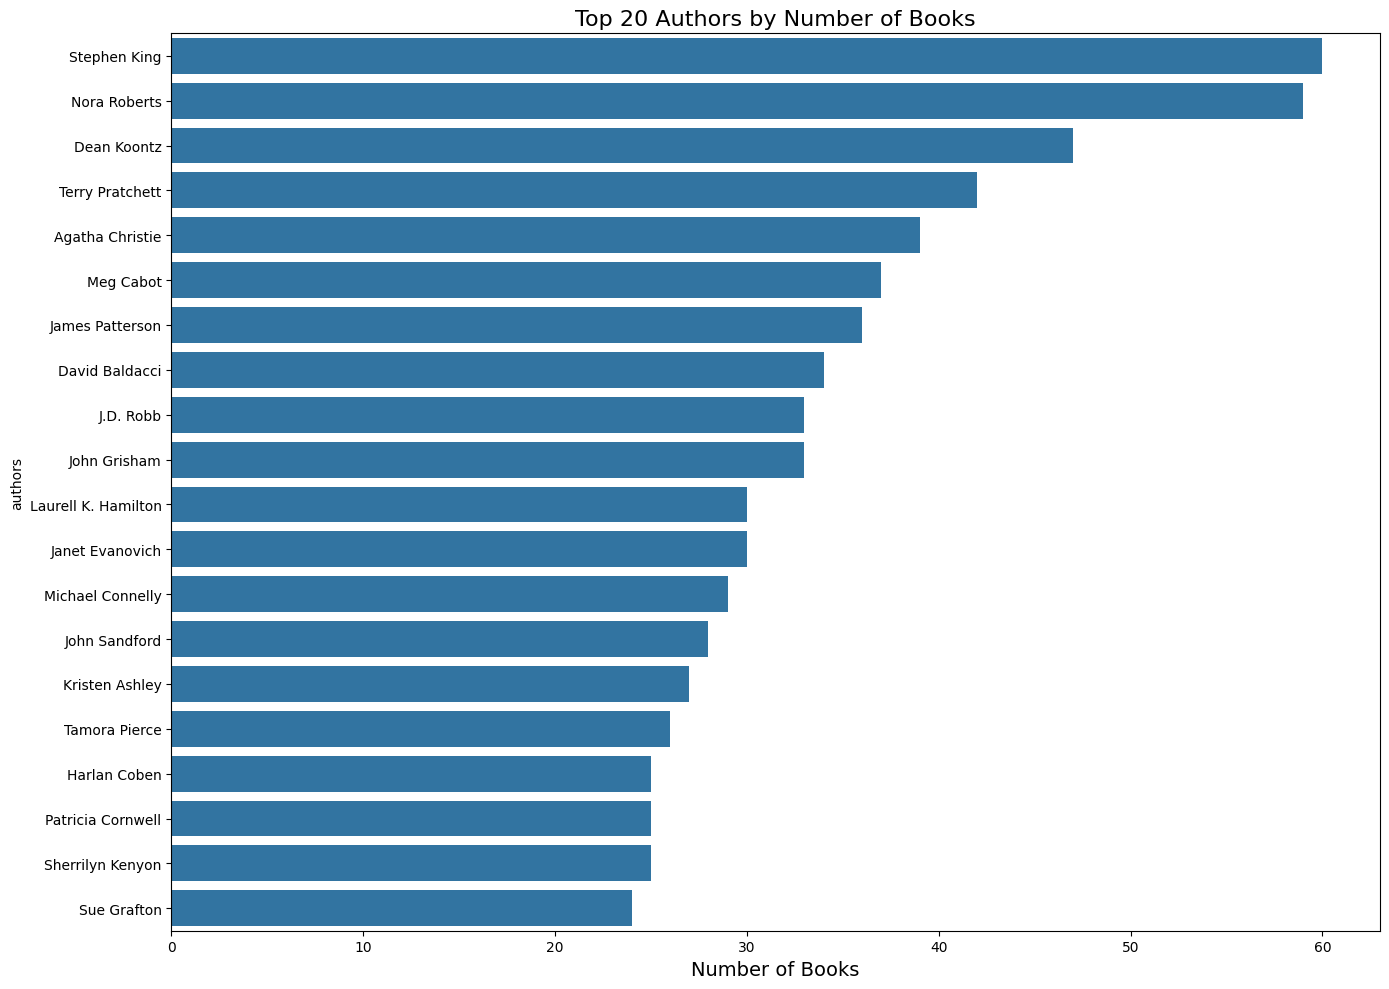


Top 20 Authors by Average Rating:
             author  avg_rating  num_books
     Kristen Ashley    4.335926         27
          J.D. Robb    4.305152         33
   Sherrilyn Kenyon    4.253200         25
      Tamora Pierce    4.196538         26
      John Sandford    4.170000         28
    Terry Pratchett    4.140238         42
   Michael Connelly    4.098966         29
       Nora Roberts    4.073390         59
     David Baldacci    4.019118         34
    James Patterson    4.003889         36
       Harlan Coben    3.981600         25
       Stephen King    3.962667         60
Laurell K. Hamilton    3.958667         30
    Janet Evanovich    3.952333         30
        Sue Grafton    3.909583         24
    Agatha Christie    3.888974         39
        Dean Koontz    3.841489         47
          Meg Cabot    3.804054         37
  Patricia Cornwell    3.781600         25
       John Grisham    3.765152         33


In [23]:
# author analysis
if 'authors' in books_df.columns:
    # top 20 authors
    top_authors = books_df['authors'].value_counts().head(20)
    
    plt.figure(figsize=(14, 10))
    sns.barplot(x=top_authors.values, y=top_authors.index)
    plt.title('Top 20 Authors by Number of Books', fontsize=16)
    plt.xlabel('Number of Books', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # average rating by top authors
    author_ratings = {}
    for author in top_authors.index:
        author_books = books_df[books_df['authors'] == author]
        avg_rating = author_books['average_rating'].mean()
        author_ratings[author] = avg_rating
    
    author_df = pd.DataFrame({
        'author': list(author_ratings.keys()),
        'avg_rating': list(author_ratings.values()),
        'num_books': [top_authors[author] for author in author_ratings.keys()]
    }).sort_values('avg_rating', ascending=False)
    
    print("\nTop 20 Authors by Average Rating:")
    print(author_df[['author', 'avg_rating', 'num_books']].to_string(index=False))

## Tag Analysis

In [24]:
# merge tags data
merged_tags = book_tags_df.merge(tags_df, on='tag_id')

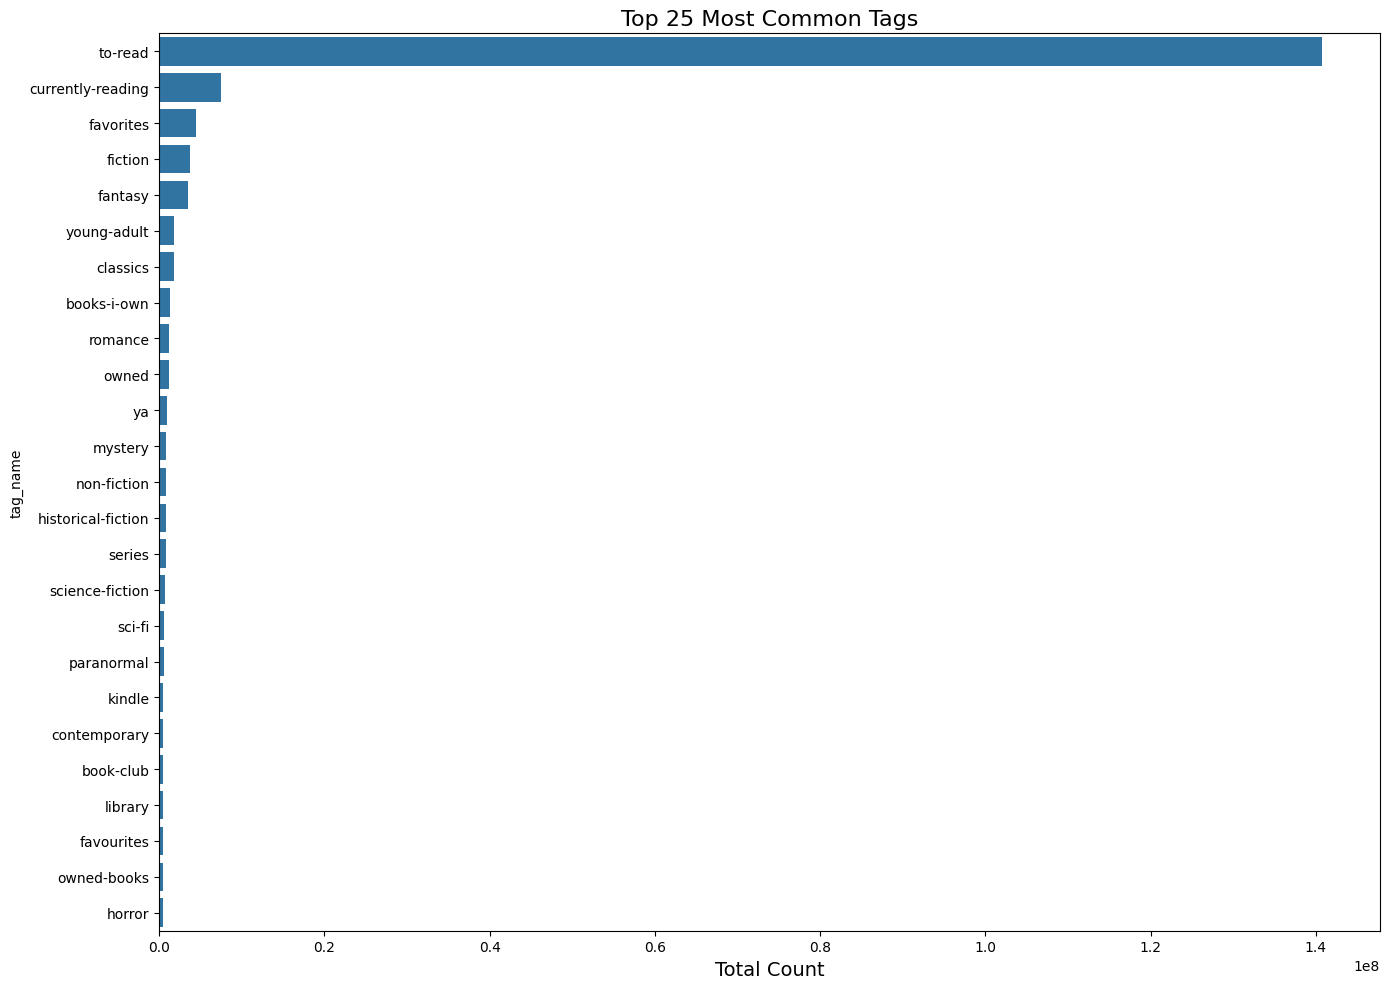

In [25]:
# top 25 most common tags
top_tags = merged_tags.groupby('tag_name')['count'].sum().sort_values(ascending=False).head(25)

plt.figure(figsize=(14, 10))
sns.barplot(x=top_tags.values, y=top_tags.index)
plt.title('Top 25 Most Common Tags', fontsize=16)
plt.xlabel('Total Count', fontsize=14)
plt.tight_layout()
plt.show()

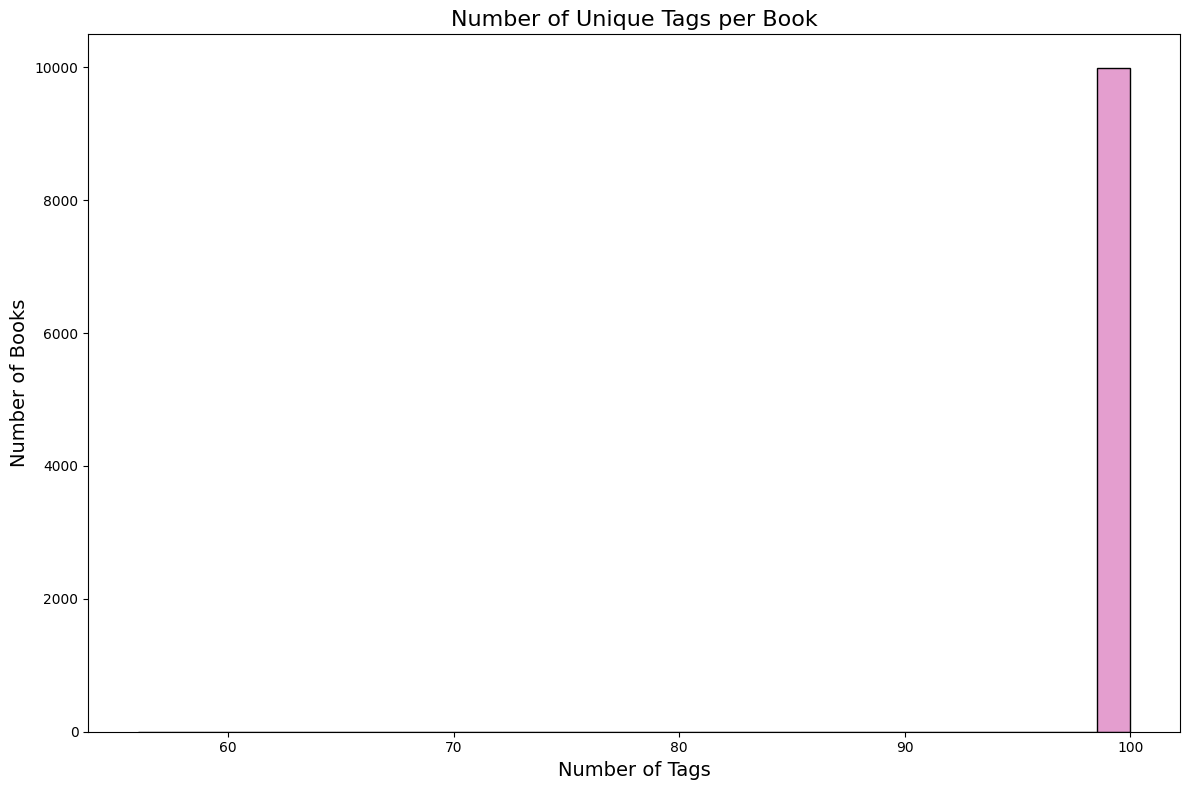


Tag Statistics:
Average number of tags per book: 99.99
Maximum number of tags for a book: 100
Books with no tags: 0


In [26]:
# number of unique tags per book
tags_per_book = merged_tags.groupby('goodreads_book_id').size()

plt.figure(figsize=(12, 8))
sns.histplot(tags_per_book, bins=30, color=colors[6])
plt.title('Number of Unique Tags per Book', fontsize=16)
plt.xlabel('Number of Tags', fontsize=14)
plt.ylabel('Number of Books', fontsize=14)
plt.tight_layout()
plt.show()

print("\nTag Statistics:")
print(f"Average number of tags per book: {tags_per_book.mean():.2f}")
print(f"Maximum number of tags for a book: {tags_per_book.max()}")
print(f"Books with no tags: {10000 - len(tags_per_book)}")

In [28]:
# most-tagged books
most_tagged_books = tags_per_book.sort_values(ascending=False).head(10)
most_tagged_df = pd.DataFrame({
    'goodreads_book_id': most_tagged_books.index,
    'num_tags': most_tagged_books.values
})

# merge with book info
most_tagged_df = most_tagged_df.merge(books_df[['goodreads_book_id', 'title', 'authors']], on='goodreads_book_id')

print("\nMost Tagged Books:")
print(most_tagged_df[['title', 'authors', 'num_tags']].to_string(index=False))


Most Tagged Books:
                                                    title                                                                authors  num_tags
Harry Potter and the Half-Blood Prince (Harry Potter, #6)                                            J.K. Rowling, Mary GrandPré       100
                                 The Stand: Captain Trips Roberto Aguirre-Sacasa, Stephen King, Mike Perkins, Laura       Martin       100
                                                    After                                                               Amy Efaw       100
                       Pursuit of Honor (Mitch Rapp, #12)                                                            Vince Flynn       100
                              Hush, Hush (Hush, Hush, #1)                                                      Becca Fitzpatrick       100
       Vampire Academy Collection (Vampire Academy, #1-3)                                                          Richelle Mead       100
       

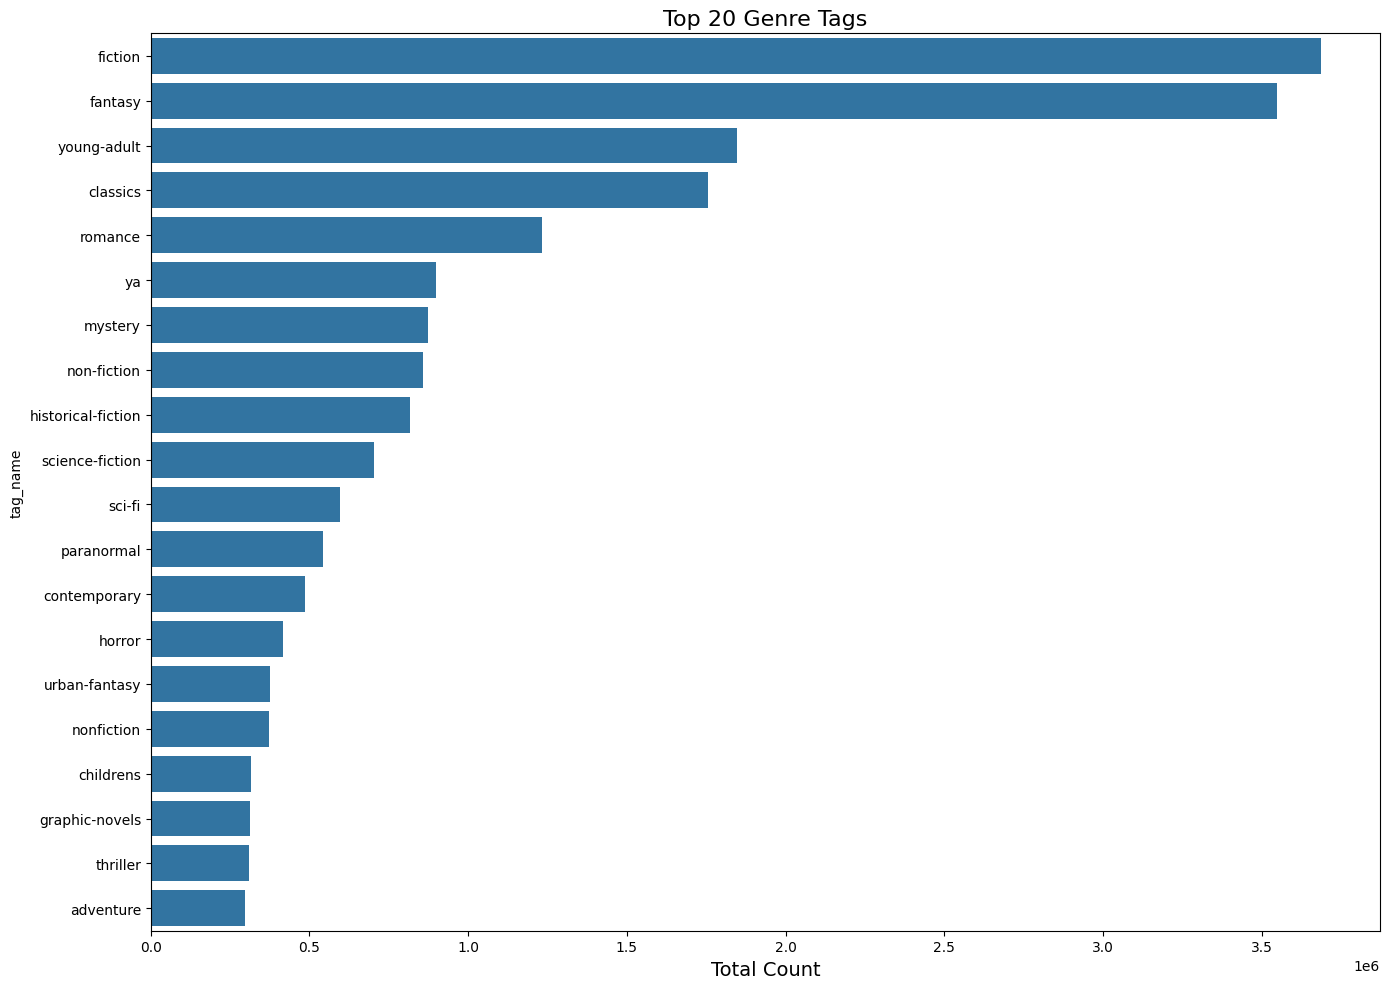

In [29]:
# find popular genres (filter out non-genre tags)
# common genre tags to look for
genre_keywords = ['fiction', 'romance', 'fantasy', 'mystery', 'thriller', 'science-fiction', 
                 'sci-fi', 'horror', 'non-fiction', 'young-adult', 'ya', 'historical', 
                 'biography', 'memoir', 'contemporary', 'classics', 'adventure', 'crime', 
                 'dystopian', 'paranormal', 'humor', 'comedy', 'poetry', 'philosophy', 
                 'psychology', 'self-help', 'children', 'graphic', 'comics']


# filter tags containing genre keywords
genre_tags = merged_tags[merged_tags['tag_name'].str.lower().str.contains('|'.join(genre_keywords))]
top_genres = genre_tags.groupby('tag_name')['count'].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(14, 10))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title('Top 20 Genre Tags', fontsize=16)
plt.xlabel('Total Count', fontsize=14)
plt.tight_layout()
plt.show()

In [30]:
# analyze average ratings by top genres
top_genre_names = top_genres.index
genre_ratings = {}

for genre in top_genre_names:
    # get books with this genre tag
    genre_book_ids = genre_tags[genre_tags['tag_name'] == genre]['goodreads_book_id'].unique()
    
    # get the average rating for these books
    if len(genre_book_ids) > 0:
        genre_books = books_df[books_df['goodreads_book_id'].isin(genre_book_ids)]
        avg_rating = genre_books['average_rating'].mean()
        genre_ratings[genre] = (avg_rating, len(genre_book_ids))

In [31]:
# create a DataFrame and sort by average rating
genre_df = pd.DataFrame({
    'genre': list(genre_ratings.keys()),
    'avg_rating': [r[0] for r in genre_ratings.values()],
    'num_books': [r[1] for r in genre_ratings.values()]
}).sort_values('avg_rating', ascending=False)

print("\nGenre Ratings:")
print(genre_df.to_string(index=False))


Genre Ratings:
             genre  avg_rating  num_books
    graphic-novels    4.203585        491
         childrens    4.100451       1354
     urban-fantasy    4.093889       1427
           fantasy    4.058410       4259
         adventure    4.054652       3661
        paranormal    4.050629       1941
                ya    4.032685       2842
            sci-fi    4.032479       2227
   science-fiction    4.031031       2222
       young-adult    4.030873       3630
        nonfiction    4.025761       1833
          classics    4.025002       2785
       non-fiction    4.017679       2128
           romance    3.998908       4251
           fiction    3.998297       9097
            horror    3.988462       1372
           mystery    3.982702       3686
          thriller    3.969167       2522
historical-fiction    3.965676       2590
      contemporary    3.947344       5287


## To-Read Analysis

In [32]:
# number of to-read entries per user
to_read_per_user = to_read_df.groupby('user_id').size()

print("\nTo-Read Statistics per User:")
print(f"Minimum to-read books per user: {to_read_per_user.min()}")
print(f"Maximum to-read books per user: {to_read_per_user.max()}")
print(f"Mean to-read books per user: {to_read_per_user.mean():.2f}")
print(f"Median to-read books per user: {to_read_per_user.median()}")


To-Read Statistics per User:
Minimum to-read books per user: 1
Maximum to-read books per user: 117
Mean to-read books per user: 18.68
Median to-read books per user: 14.0


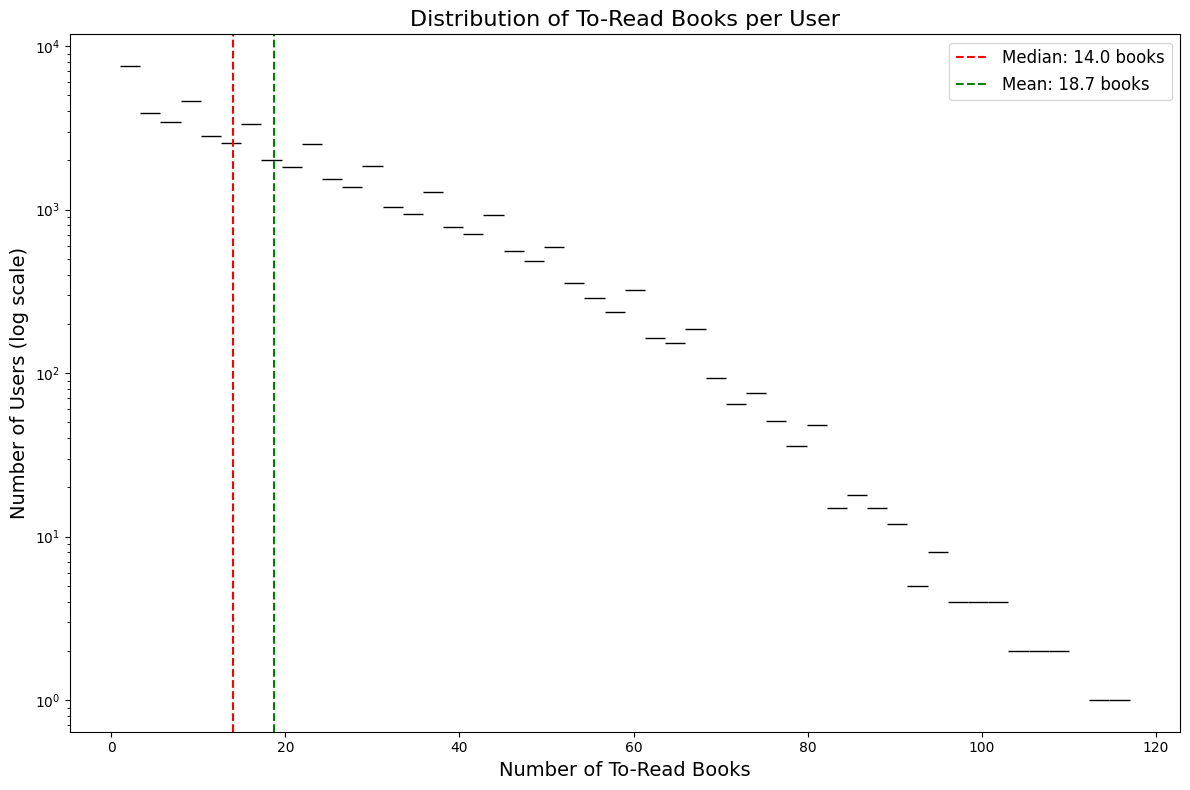

In [33]:
# plot distribution of to-read books per user
plt.figure(figsize=(12, 8))
sns.histplot(to_read_per_user, bins=50, log_scale=(False, True), color=colors[7])
plt.axvline(x=to_read_per_user.median(), color='red', linestyle='--', 
            label=f'Median: {to_read_per_user.median()} books')
plt.axvline(x=to_read_per_user.mean(), color='green', linestyle='--', 
            label=f'Mean: {to_read_per_user.mean():.1f} books')
plt.title('Distribution of To-Read Books per User', fontsize=16)
plt.xlabel('Number of To-Read Books', fontsize=14)
plt.ylabel('Number of Users (log scale)', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [34]:
# most popular to-read books
to_read_per_book = to_read_df.groupby('book_id').size()
top_to_read = to_read_per_book.sort_values(ascending=False).head(20)

top_to_read_df = pd.DataFrame({
    'book_id': top_to_read.index,
    'to_read_count': top_to_read.values
})

In [35]:
# merge with book info and ratings
top_to_read_df = top_to_read_df.merge(books_df[['book_id', 'title', 'authors', 'average_rating']], on='book_id')
top_to_read_df['rating_count'] = [book_rating_counts.get(book_id, 0) for book_id in top_to_read_df['book_id']]
top_to_read_df['to_read_to_rated_ratio'] = top_to_read_df['to_read_count'] / top_to_read_df['rating_count']

print("\nTop 20 Most Want-to-Read Books:")
print(top_to_read_df[['title', 'authors', 'to_read_count', 'rating_count', 'average_rating', 'to_read_to_rated_ratio']].to_string(index=False))


Top 20 Most Want-to-Read Books:
                                                                               title                                 authors  to_read_count  rating_count  average_rating  to_read_to_rated_ratio
                                                                      The Book Thief                            Markus Zusak           2772         10394            4.36                0.266692
                                                         All the Light We Cannot See                           Anthony Doerr           1967          6082            4.31                0.323413
                                                                            Catch-22                           Joseph Heller           1840          6944            3.98                0.264977
                                                                                1984 George Orwell, Erich Fromm, Celâl Üster           1812         14693            4.14                0.1233

Books with both ratings and to-read entries: 9986


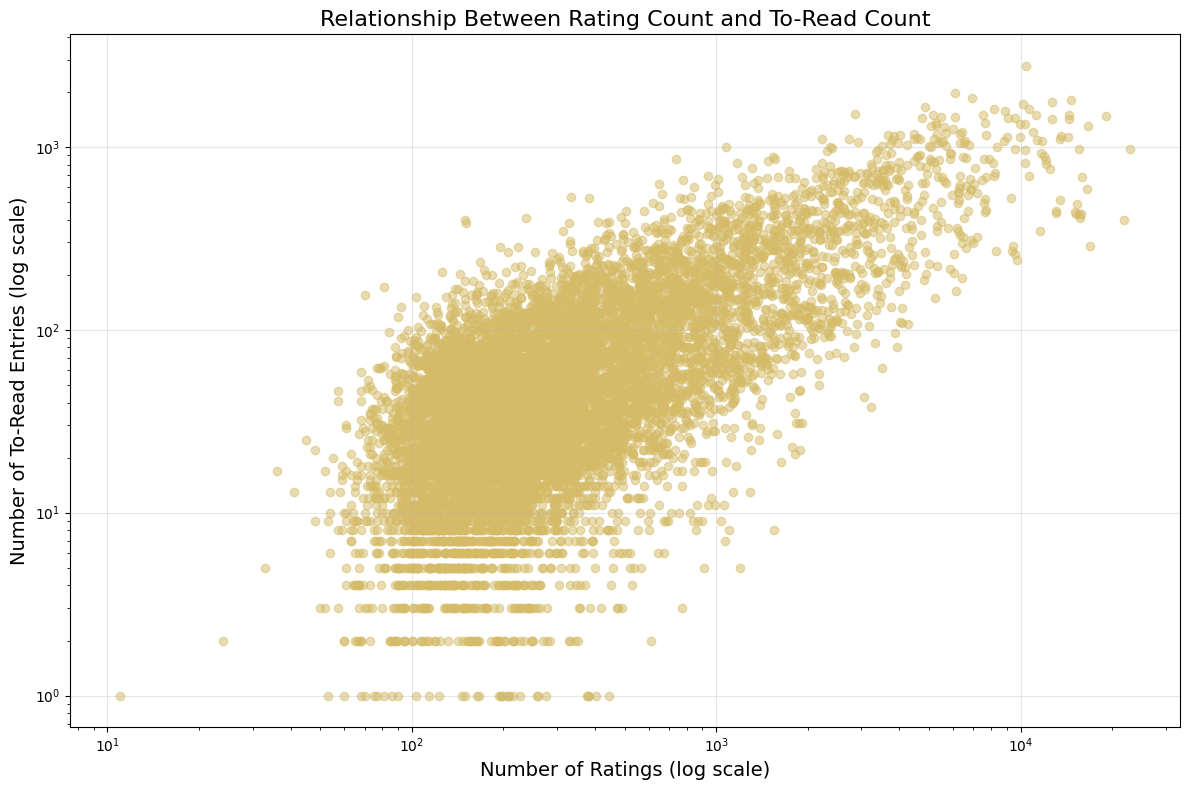

In [38]:
# relationship between to-read count and rating count
# first, find books that are in both datasets
common_book_ids = set(book_rating_counts.index).intersection(set(to_read_per_book.index))
print(f"Books with both ratings and to-read entries: {len(common_book_ids)}")

# create aligned lists for plotting
x_values = [book_rating_counts[book_id] for book_id in common_book_ids]
y_values = [to_read_per_book[book_id] for book_id in common_book_ids]

# plot with the aligned data
plt.figure(figsize=(12, 8))
plt.scatter(x_values, y_values, alpha=0.5, color=colors[8])
plt.xscale('log')
plt.yscale('log')
plt.title('Relationship Between Rating Count and To-Read Count', fontsize=16)
plt.xlabel('Number of Ratings (log scale)', fontsize=14)
plt.ylabel('Number of To-Read Entries (log scale)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:

# calculate correlation with the aligned data
correlation = np.corrcoef(x_values, y_values)[0, 1]
print(f"\nCorrelation between number of ratings and to-read count: {correlation:.3f}")


Correlation between number of ratings and to-read count: 0.729


In [40]:
# books that are often added to to-read but rarely rated
to_read_ratio = {}
common_books = set(book_rating_counts.index).intersection(set(to_read_per_book.index))
for book_id in common_books:
    ratio = to_read_per_book[book_id] / book_rating_counts[book_id]
    to_read_ratio[book_id] = ratio

In [41]:
# get top books by to-read to rating ratio (min 100 to-read)
high_ratio_books = {k: v for k, v in to_read_ratio.items() if to_read_per_book[k] >= 100}
top_ratio_books = sorted(high_ratio_books.items(), key=lambda x: x[1], reverse=True)[:10]

top_ratio_df = pd.DataFrame({
    'book_id': [t[0] for t in top_ratio_books],
    'to_read_to_rated_ratio': [t[1] for t in top_ratio_books],
    'to_read_count': [to_read_per_book[t[0]] for t in top_ratio_books],
    'rating_count': [book_rating_counts[t[0]] for t in top_ratio_books]
})

In [42]:
# merge with book info
top_ratio_df = top_ratio_df.merge(books_df[['book_id', 'title', 'authors', 'average_rating']], on='book_id')

print("\nBooks Often Added to To-Read but Rarely Rated:")
print(top_ratio_df[['title', 'authors', 'to_read_count', 'rating_count', 'to_read_to_rated_ratio', 'average_rating']].to_string(index=False))


Books Often Added to To-Read but Rarely Rated:
                                                                                                                                         title           authors  to_read_count  rating_count  to_read_to_rated_ratio  average_rating
                                                                              James Potter and the Hall of Elders' Crossing (James Potter, #1) G. Norman Lippert            400           149                2.684564            3.78
                                                                                   A Court of Wings and Ruin (A Court of Thorns and Roses, #3)     Sarah J. Maas            384           151                2.543046            4.54
                                                                                                                             The Elephant Tree       R.D. Ronald            154            70                2.200000            3.52
                                

## User Engagement Analysis

In [43]:
# get unique users in each dataset
rating_users = set(ratings_df['user_id'].unique())
toread_users = set(to_read_df['user_id'].unique())

In [44]:
# find overlaps and exclusives
users_both = rating_users.intersection(toread_users)
only_rating = rating_users - toread_users
only_toread = toread_users - rating_users

print("\nUser Engagement Analysis:")
print(f"Total unique users across both activities: {len(rating_users.union(toread_users))}")
print(f"Users who rated books: {len(rating_users)}")
print(f"Users who marked books to-read: {len(toread_users)}")
print(f"Users who both rated and marked to-read: {len(users_both)}")
print(f"Users who only rated books: {len(only_rating)}")
print(f"Users who only marked books to-read: {len(only_toread)}")


User Engagement Analysis:
Total unique users across both activities: 53424
Users who rated books: 53424
Users who marked books to-read: 48871
Users who both rated and marked to-read: 48871
Users who only rated books: 4553
Users who only marked books to-read: 0


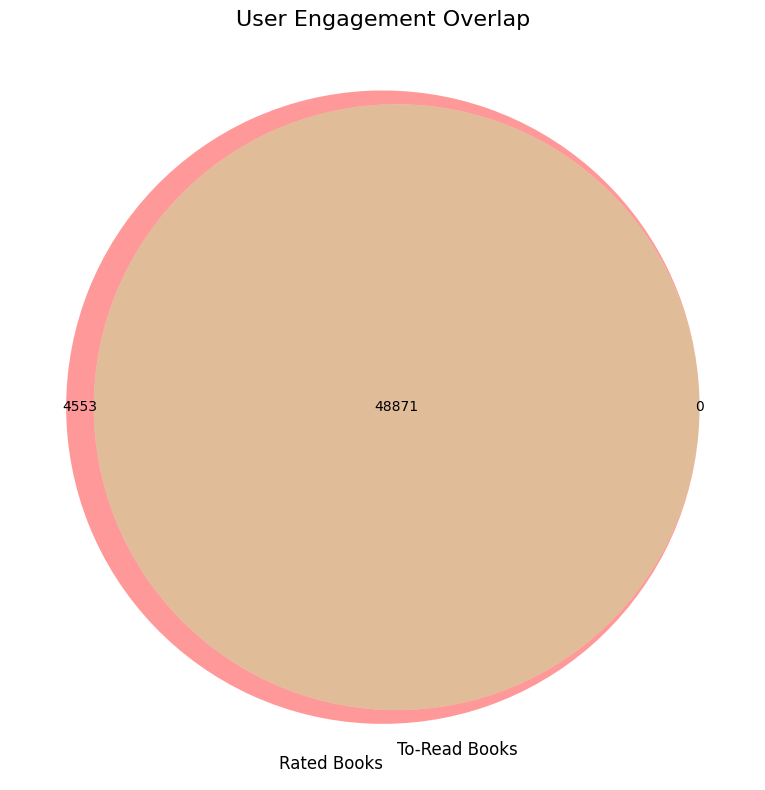

In [45]:
# Create a venn diagram
plt.figure(figsize=(10, 8))
from matplotlib_venn import venn2
venn2([rating_users, toread_users], ('Rated Books', 'To-Read Books'))
plt.title('User Engagement Overlap', fontsize=16)
plt.tight_layout()
plt.show()


Activity Levels:
Avg ratings for users who only rate: 114.47
Avg ratings for users who do both: 111.63
Avg to-read for users who only mark to-read: nan
Avg to-read for users who do both: 18.68


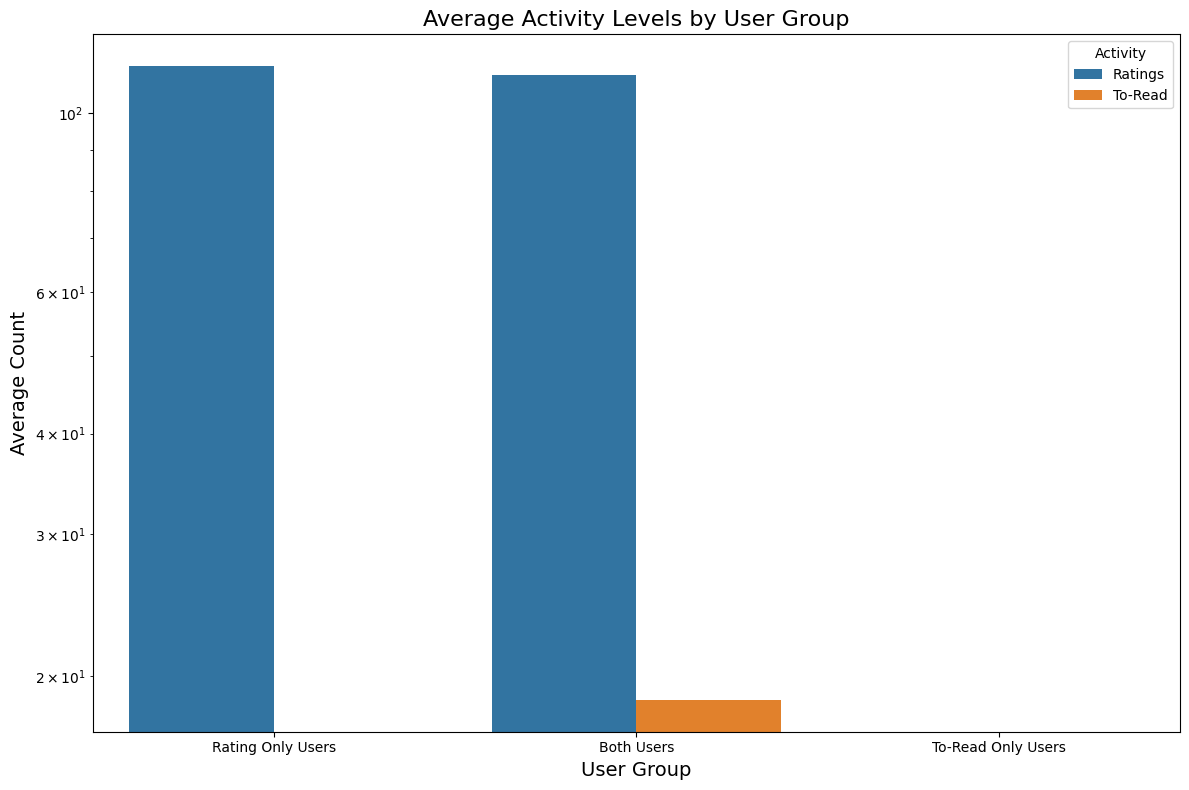

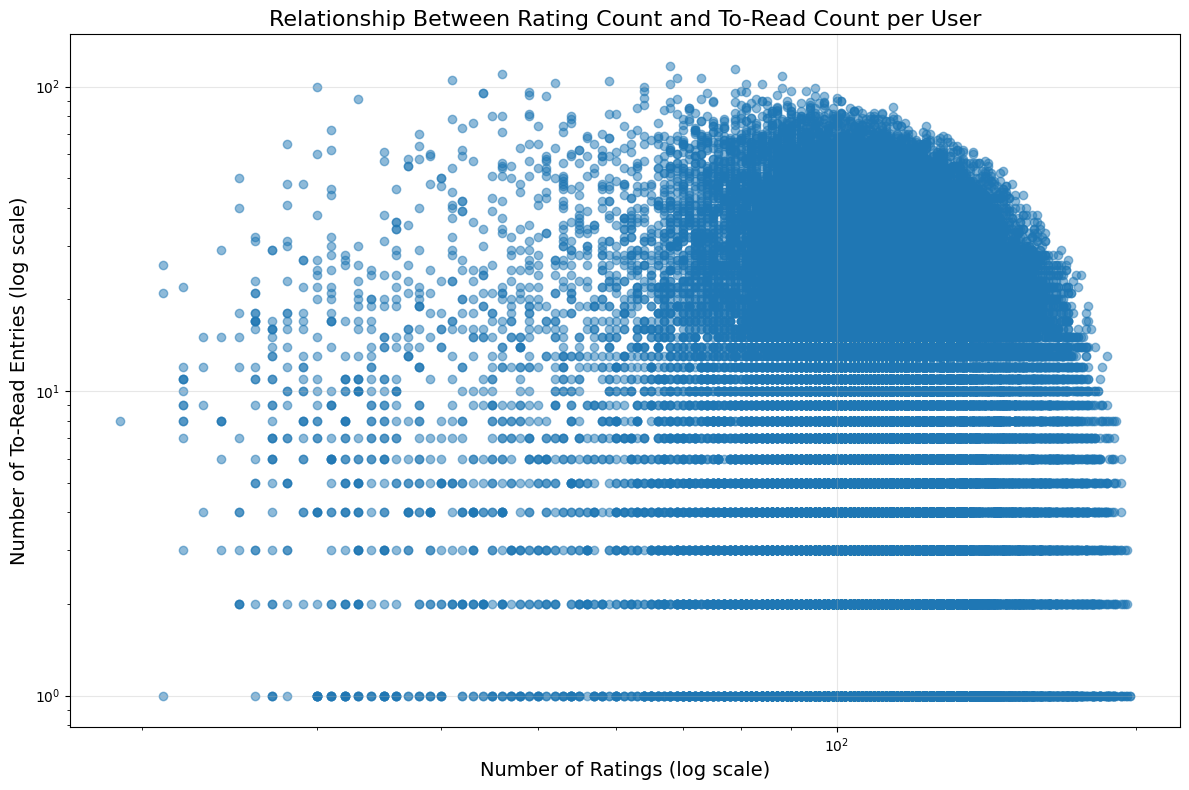


Correlation between rating count and to-read count per user: -0.150


In [46]:
# compare activity levels
if len(users_both) > 0:
    both_rating_counts = ratings_df[ratings_df['user_id'].isin(users_both)]['user_id'].value_counts()
    both_toread_counts = to_read_df[to_read_df['user_id'].isin(users_both)]['user_id'].value_counts()
    
    only_rating_counts = ratings_df[ratings_df['user_id'].isin(only_rating)]['user_id'].value_counts()
    only_toread_counts = to_read_df[to_read_df['user_id'].isin(only_toread)]['user_id'].value_counts()
    
    print("\nActivity Levels:")
    print(f"Avg ratings for users who only rate: {only_rating_counts.mean():.2f}")
    print(f"Avg ratings for users who do both: {both_rating_counts.mean():.2f}")
    print(f"Avg to-read for users who only mark to-read: {only_toread_counts.mean():.2f}")
    print(f"Avg to-read for users who do both: {both_toread_counts.mean():.2f}")
    
    # plot comparison
    activity_data = {
        'Group': ['Rating Only Users', 'Both Users', 'To-Read Only Users', 'Both Users'],
        'Activity': ['Ratings', 'Ratings', 'To-Read', 'To-Read'],
        'Average Count': [only_rating_counts.mean(), both_rating_counts.mean(), 
                         only_toread_counts.mean(), both_toread_counts.mean()]
    }
    
    activity_df = pd.DataFrame(activity_data)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Group', y='Average Count', hue='Activity', data=activity_df)
    plt.title('Average Activity Levels by User Group', fontsize=16)
    plt.xlabel('User Group', fontsize=14)
    plt.ylabel('Average Count', fontsize=14)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # analyze correlation between rating and to-read behavior for users who do both
    if len(users_both) > 0:
        common_user_activity = []
        for user in users_both:
            rating_count = ratings_df[ratings_df['user_id'] == user].shape[0]
            toread_count = to_read_df[to_read_df['user_id'] == user].shape[0]
            common_user_activity.append((user, rating_count, toread_count))
        
        common_df = pd.DataFrame(common_user_activity, columns=['user_id', 'rating_count', 'toread_count'])
        
        plt.figure(figsize=(12, 8))
        plt.scatter(common_df['rating_count'], common_df['toread_count'], alpha=0.5)
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Relationship Between Rating Count and To-Read Count per User', fontsize=16)
        plt.xlabel('Number of Ratings (log scale)', fontsize=14)
        plt.ylabel('Number of To-Read Entries (log scale)', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # calculate correlation
        correlation = np.corrcoef(common_df['rating_count'], common_df['toread_count'])[0, 1]
        print(f"\nCorrelation between rating count and to-read count per user: {correlation:.3f}")